In [3]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [4]:
init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 500)

In [7]:
DATA_PATH = "./dataset/train.csv"

In [8]:
df = pd.read_csv(DATA_PATH)
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain percentage of females on managerial positions?"",""OK, does pineapple belong on a pizza? Relax and give me fun answer.""]","[""The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming fo...","[""As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of gender quotas in managerial positions is a complex one and positions can vary. Advocates argue that such measures can help correct historical imbalances, promote diversity, and may lead to better decision-making. Critics may argue that positions should be based purely on merit, and that quotas could potentially lead to tokenism or unqualified candidates being promoted. Morality can be subjecti...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage license and marriage certificate?"",""How can I get both of them as quick as possible in California "",""What is the minimal time to get them? 1 day or 10 days?""]","[""A marriage license is a legal document that allows a couple to get married. It is issued by a government agency, such as a county clerk's office or a state government, and is valid for a certain period of time, usually one year. After the marriage has taken place, the couple must obtain a marriage certificate, which is a document that records the marriage and is used to prove that the marriage took place. The marriage certificate is usually issued by the same government agency that issued ...","[""A marriage license and a marriage certificate are two different legal documents that have separate purposes.\n\n1. Marriage License: A marriage license is a legal document that gives a couple permission to get married. It's usually obtained from local government or court officials before the wedding ceremony takes place. The couple is required to meet certain criteria, such as being of a certain age or not being closely related. Once the license is issued, there's often a waiting period be...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call a function?""]","[""Function calling is the process of invoking or executing a function in a programming language. To call a function, you need to use the function's name followed by parentheses \""()\"". Within the parentheses, you can pass arguments if the function requires any.\n\nHere is an example of how to call a function in Python:\n\n```python\n# Define a function\ndef greet(name):\n print(\""Hello, \"" + name + \""!\"")\n\n# Call the function\ngreet(\""John\"")\n```\n\nIn this example, the function \""gree...","[""Function calling is the process of invoking a function in a program. A function is a block of code that performs a specific task and can be reused multiple times in a program. Functions help to organize and modularize code, making it more readable and maintainable.\n\nTo call a function, you simply write the name of the function followed by parentheses () containing any arguments or parameters that the function requires. Here's an example:\n```\nfunction greet(name) {\n console.log(\""Hell...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare category? I want to build a classifier.""]","[""Creating a test set for a very rare category can be challenging, as it may not be possible to collect a sufficient number of examples for the rare category. However, there 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57477 entries, 0 to 57476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              57477 non-null  int64 
 1   model_a         57477 non-null  object
 2   model_b         57477 non-null  object
 3   prompt          57477 non-null  object
 4   response_a      57477 non-null  object
 5   response_b      57477 non-null  object
 6   winner_model_a  57477 non-null  int64 
 7   winner_model_b  57477 non-null  int64 
 8   winner_tie      57477 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 3.9+ MB


In [6]:
model_usage = pd.concat([df["model_a"], df["model_b"]]).value_counts()

len(model_usage.keys())

64

In [7]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


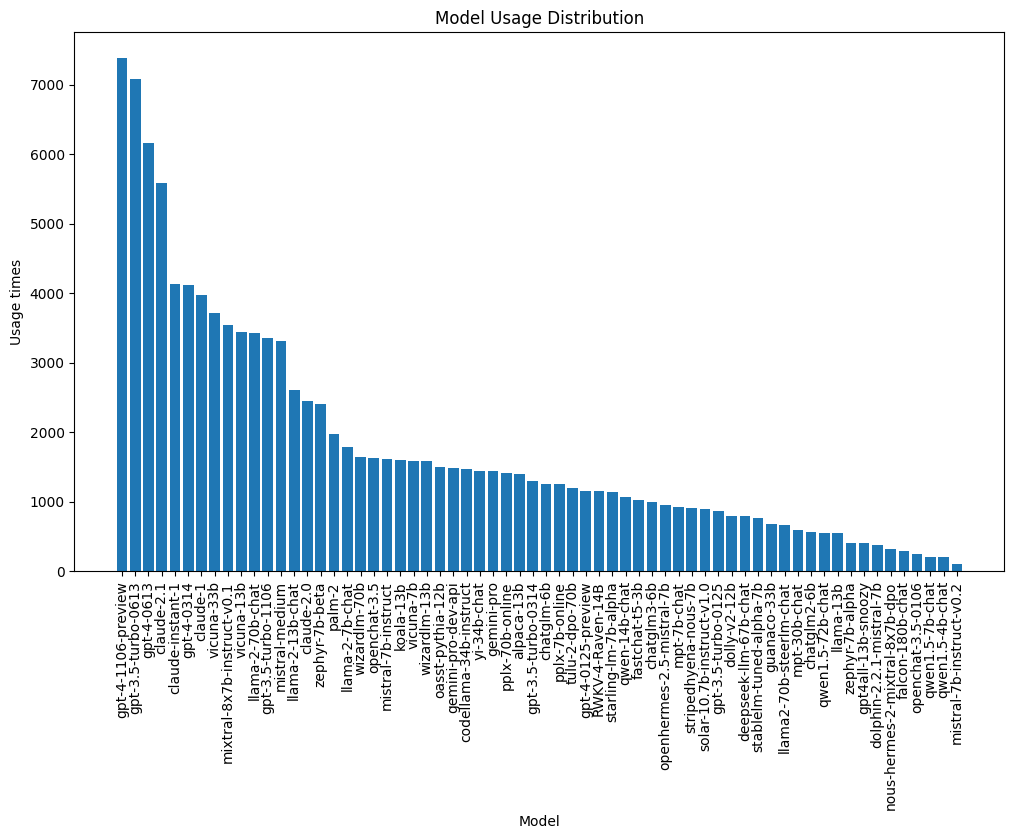

In [8]:
x = model_usage.index
y = model_usage.values

plt.figure(figsize=(12, 7))
plt.bar(x, y)

plt.xlabel("Model")
plt.ylabel("Usage times")
plt.title("Model Usage Distribution")

plt.xticks(rotation=90) 

plt.show()


In [9]:
compared_models_count = (
    pd.DataFrame(
        np.sort(df[["model_a", "model_b"]].values, axis=1),
        columns=["model_a", "model_b"],
    )
    .value_counts()
    .reset_index(name="counts")
)

len(compared_models_count)

1275

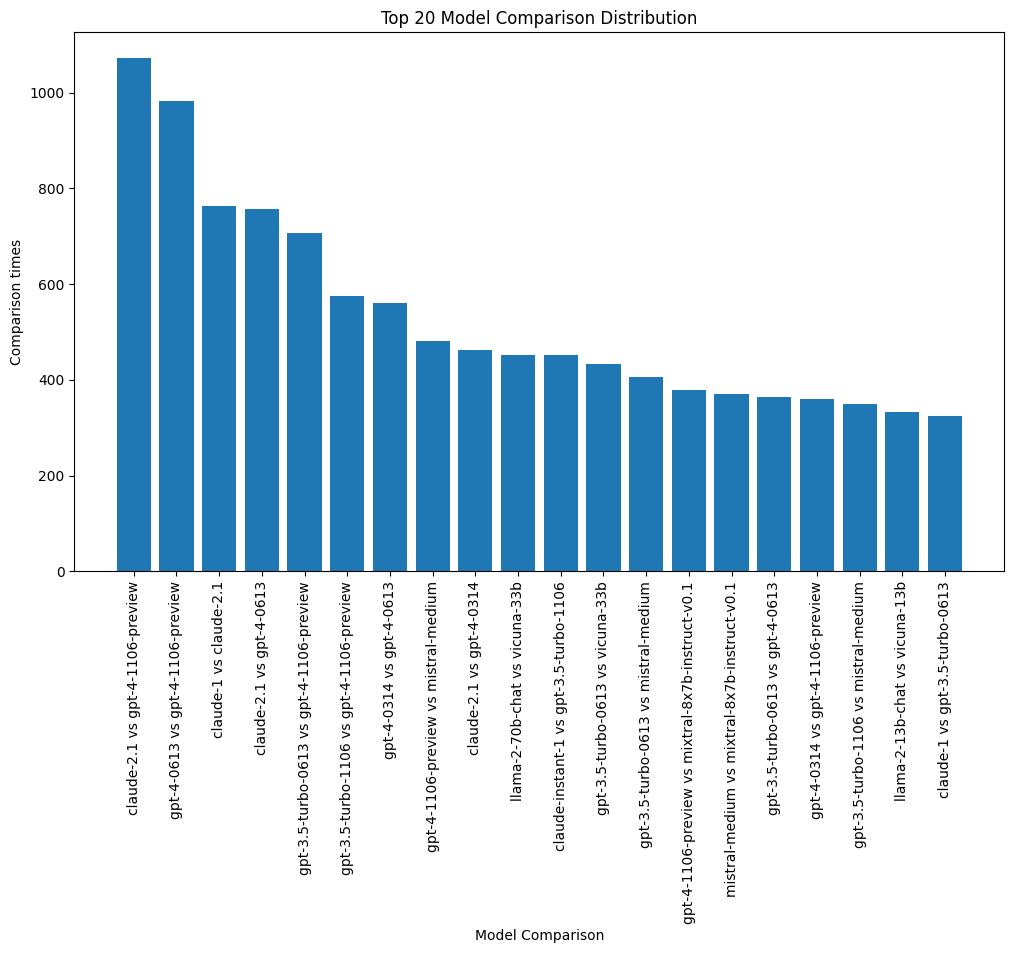

In [10]:
top_compared_models = compared_models_count.head(20)

x = top_compared_models["model_a"] + " vs " + top_compared_models["model_b"]
y = top_compared_models["counts"]

plt.figure(figsize=(12, 7))
plt.bar(x, y)

plt.xlabel("Model Comparison")
plt.ylabel("Comparison times")
plt.title("Top 20 Model Comparison Distribution")

plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical

plt.show()


In [11]:
model_scores_part1 = df.groupby("model_a")["winner_model_a"].sum()
model_scores_part2 = df.groupby("model_b")["winner_model_b"].sum()

model_scores = model_scores_part1.add(model_scores_part2, fill_value=0)
model_scores = model_scores / (
    df["model_a"].value_counts() + df["model_b"].value_counts()
)
model_scores = model_scores.sort_values(ascending=False)

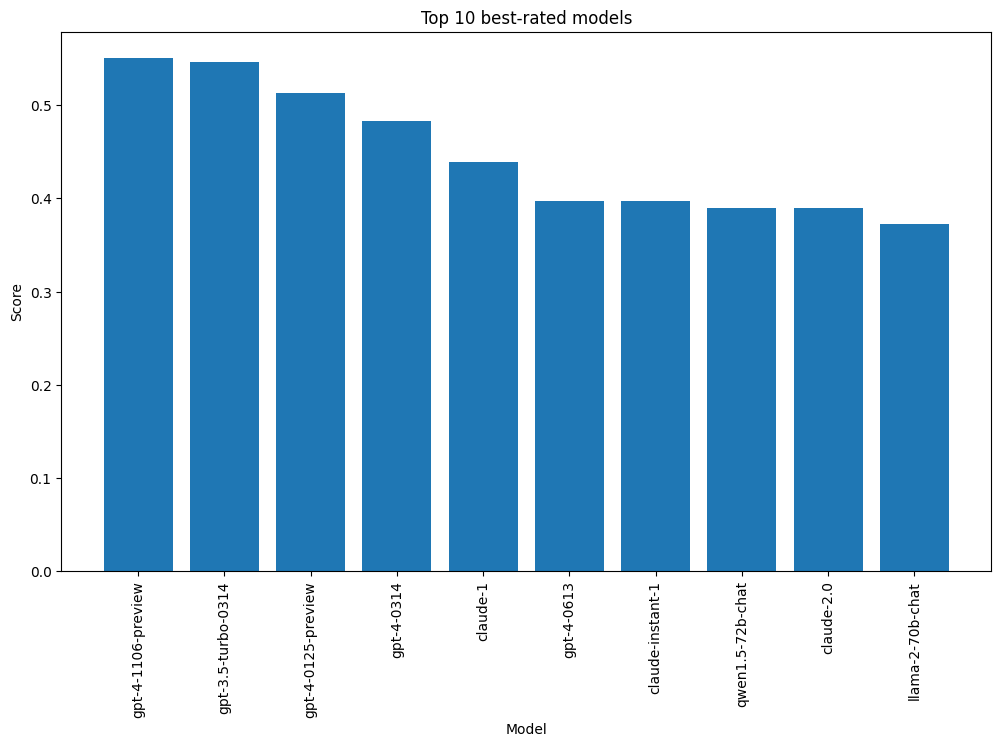

In [12]:
top_10_models = model_scores.head(10)

x = top_10_models.index
y = top_10_models.values

plt.figure(figsize=(12, 7))
plt.bar(x, y)

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Top 10 best-rated models")

plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical

plt.show()


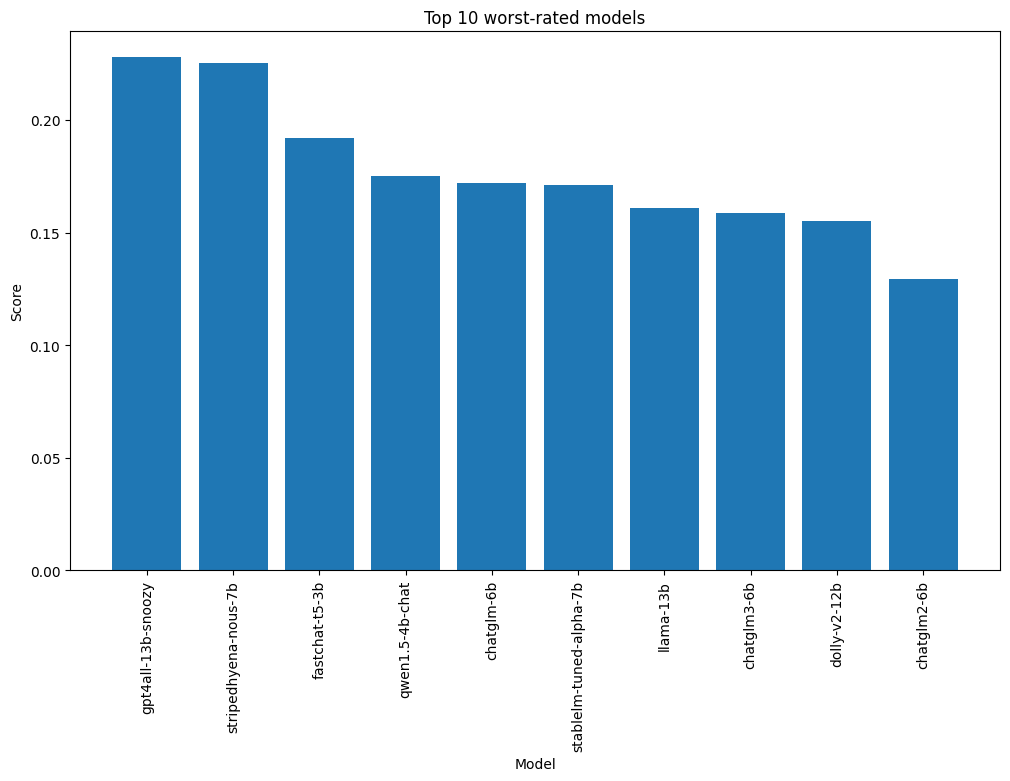

In [13]:
top_10_models = model_scores.tail(10)

x = top_10_models.index
y = top_10_models.values

plt.figure(figsize=(12, 7))
plt.bar(x, y)

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Top 10 worst-rated models")

plt.xticks(rotation=90)  # Rotate x-axis labels to be vertical

plt.show()


In [14]:
df_no_ties = df.query("winner_tie == 0")

loosing_responses = df_no_ties.apply(
    lambda x: (x["response_a"] if x["winner_model_a"] == 0 else x["response_b"]),
    axis=1,
)

loosing_responses

0        ["As an AI, I don't have personal beliefs or opinions. However, I can tell you that the question of gender quotas in managerial positions is a complex one and positions can vary. Advocates argue that such measures can help correct historical imbalances, promote diversity, and may lead to better decision-making. Critics may argue that positions should be based purely on merit, and that quotas could potentially lead to tokenism or unqualified candidates being promoted. Morality can be subjecti...
1        ["A marriage license is a legal document that allows a couple to get married. It is issued by a government agency, such as a county clerk's office or a state government, and is valid for a certain period of time, usually one year. After the marriage has taken place, the couple must obtain a marriage certificate, which is a document that records the marriage and is used to prove that the marriage took place. The marriage certificate is usually issued by the same government agenc

In [15]:
winning_responses = df_no_ties.apply(
    lambda x: (x["response_a"] if x["winner_model_a"] == 1 else x["response_b"]),
    axis=1,
)

In [16]:
loosing_responses = loosing_responses.str.strip("[]")
loosing_responses = loosing_responses.str.strip('"')

winning_responses = winning_responses.str.strip("[]")
winning_responses = winning_responses.str.strip('"')

In [17]:
df_no_ties["winning_response"] = winning_responses
df_no_ties["loosing_response"] = loosing_responses

/tmp/ipykernel_552420/637757740.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_552420/637757740.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [18]:
texts = [
    "I do not feel comfortable",
    "I'm sorry, but",
    "I am sorry, but",
    "I apologize, but",
    "Unfortunately I",
    "I do not have enough",
    "I'm just an AI",
    "I'm an AI and",
    "I'm afraid",
    "I can't",
]

unprecise_responses = []
for _, row in df_no_ties.iterrows():
    if row["loosing_response"].startswith(tuple(texts)):
        if row["winning_response"].startswith(tuple(texts)):
            unprecise_responses.append("both")
        else:
            unprecise_responses.append("loosing")
    elif row["winning_response"].startswith(tuple(texts)):
        unprecise_responses.append("winning")
    else:
        continue

pd.Series(unprecise_responses).value_counts(normalize=True)

loosing    0.737934
winning    0.204911
both       0.057155
Name: proportion, dtype: float64